### Importing Packages

In [1]:
from model import GeneratorGAN, DiscriminatorGAN
from train import trainDiscriminator, trainGenerator
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import TensorDataset
from torch.autograd.variable import Variable
import torchvision.utils as vutils
from torchvision import transforms
import torchvision.datasets as dset
import matplotlib.animation as animation
from IPython.display import HTML
import pickle as pkl

### Initializing GPU

In [2]:
print(f'CUDA available: {torch.cuda.is_available()}')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

CUDA available: True


In [3]:
root = 'seg_train'
dataset = dset.ImageFolder(root=root,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                           ]))

### Showing Images from Dataset

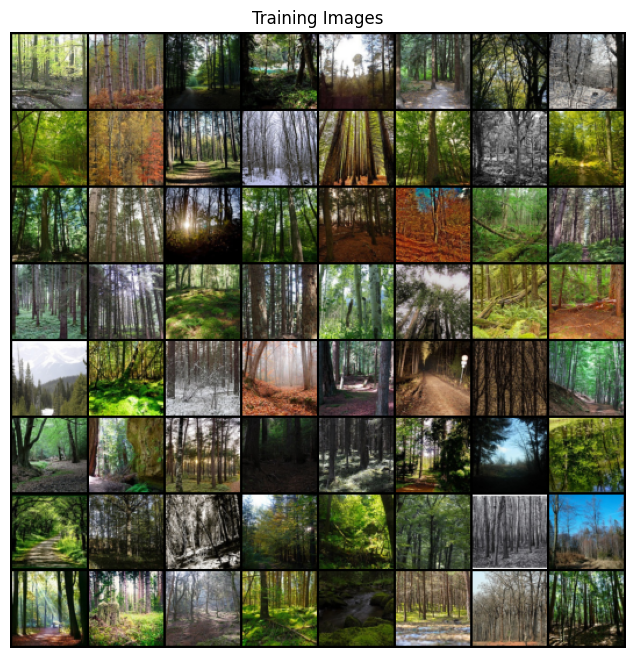

In [4]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64,
                                         shuffle=True, num_workers=2, drop_last = True)

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2).cpu(),(1,2,0)))
plt.show()

### Initializing Dataset (Just going to use buildings for now)

In [5]:
import torch
from torch.utils.data import TensorDataset


images = []
labels = []

for image, label in dataset:
    if image.shape == (3, 64, 64):
        images.append(image)
        labels.append(label)

images_tensor = torch.stack(images)  
labels_tensor = torch.tensor(labels)


tensor_dataset = TensorDataset(images_tensor, labels_tensor)
dataloader = torch.utils.data.DataLoader(tensor_dataset, batch_size=64,
                                         shuffle=True, num_workers=2, drop_last = True)


### Weight Initialization

In [6]:
def w_init(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight.data, 0, .02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1, .02)
        nn.init.constant_(m.bias.data, 0)

### Designing the Generator Architecture

In [7]:
G = GeneratorGAN()
G = G.to(device)   
G.apply(w_init)
fixed_noise = torch.rand(64, 100, 1, 1)
fixed_noise = fixed_noise.to(device)
with torch.no_grad():
    output = G(fixed_noise)
output.shape

torch.Size([64, 3, 64, 64])

### Designing the Discriminator Architecture

In [8]:
D = DiscriminatorGAN()
D = D.to(device)
D.apply(w_init)
sample_image = dataset[0][0]
sample_image = sample_image.unsqueeze(0)
sample_image = sample_image.to(device)
with torch.no_grad():
    output = D(sample_image)
output.shape

torch.Size([1, 1, 1, 1])

### Loss Functions and Optimizers

In [9]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, 100, 1, 1, device = device)

real_label = 1.
fake_label = 0.
lr = .0002
beta1 = 0.5

optimD = optim.Adam(D.parameters(), lr = lr, betas = (beta1, .999))
optimG = optim.Adam(G.parameters(), lr = lr, betas = (beta1, .999))                

### Training

In [10]:
imgs = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 100
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(dataloader):
        dError, dOutputReal, dOutputFake = trainDiscriminator(D, G, optimD, images,  device)
        gError = trainGenerator(D, G, optimG, images, device)
    if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
        with torch.no_grad():
            fake = G(torch.randn(64, 100, 1, 1).to(device)).detach().cpu()
            imgs.append(vutils.make_grid(fake, padding = 2, normalize = True))
        iters += 1

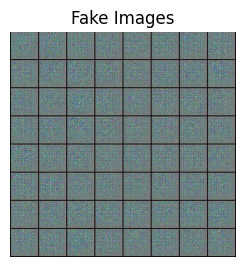

In [11]:
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(imgs[-1],(1,2,0)))
plt.show()

### Plotting Loss over Iterations

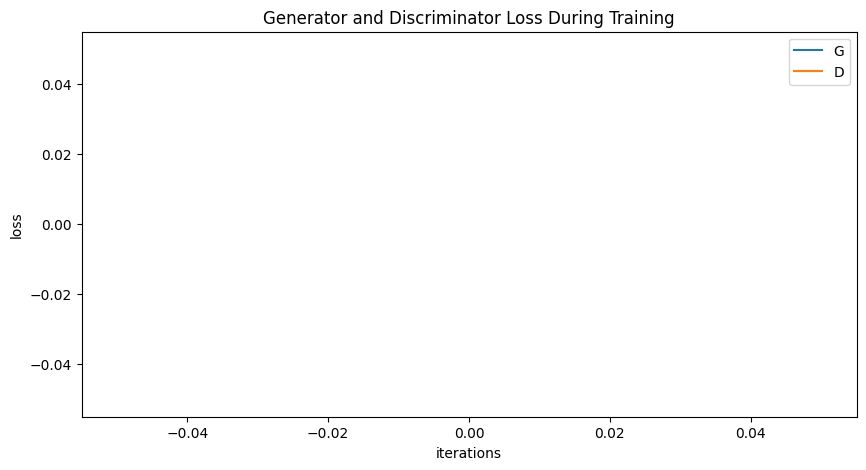

In [12]:
plt.figure(figsize = (10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label = "G")
plt.plot(D_losses, label = "D")
plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend()
plt.show()

### Generating an Image

### Showing Real vs Fake Images

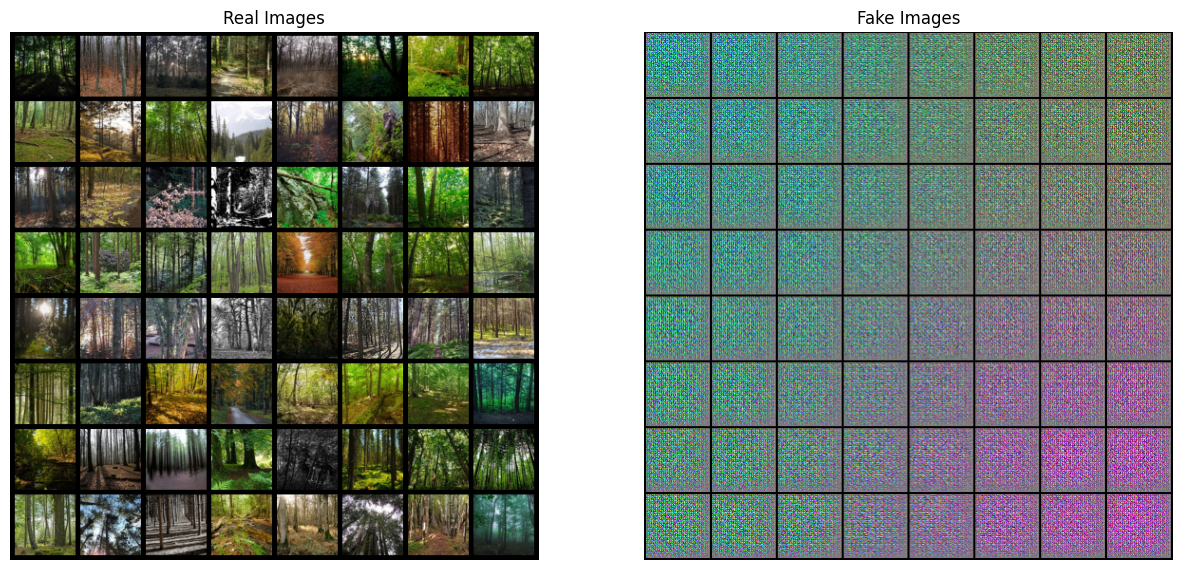

In [13]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(imgs[-1],(1,2,0)))
plt.show()